Current working directory: /Users/yashwanthberi/final resume projects


/var/folders/pc/3j6vzt2j0qngfxrt12nd0hyh0000gn/T/ipykernel_59938/3496549642.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(file_path, parse_dates=['Dates'])


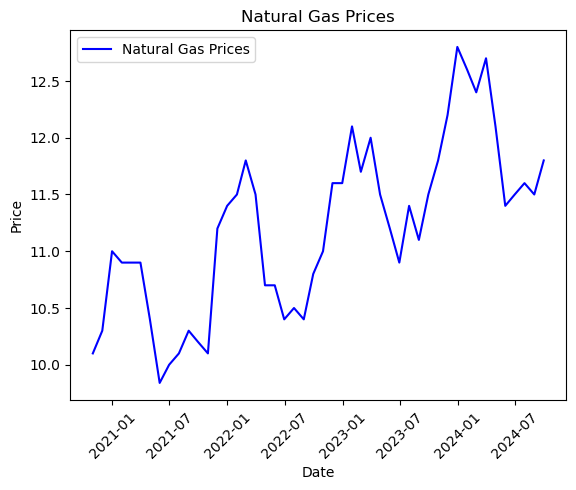

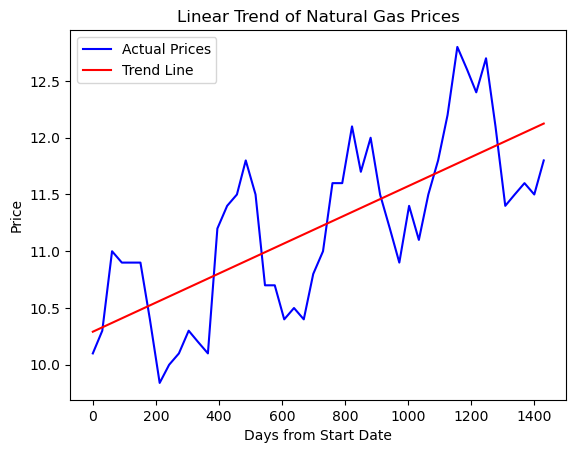

Slope: 0.0013, Intercept: 10.2910


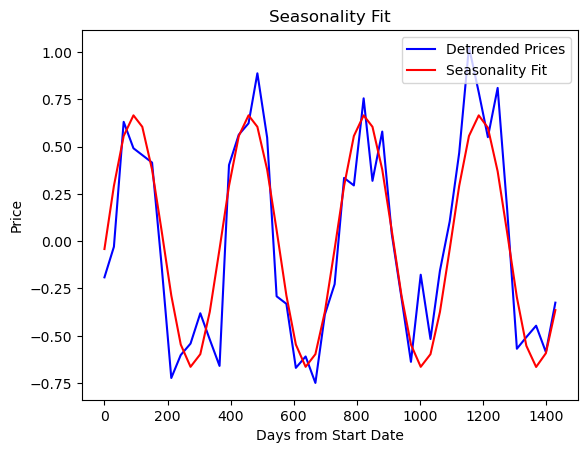

Amplitude: 0.6658, Phase Shift: -0.0622 radians


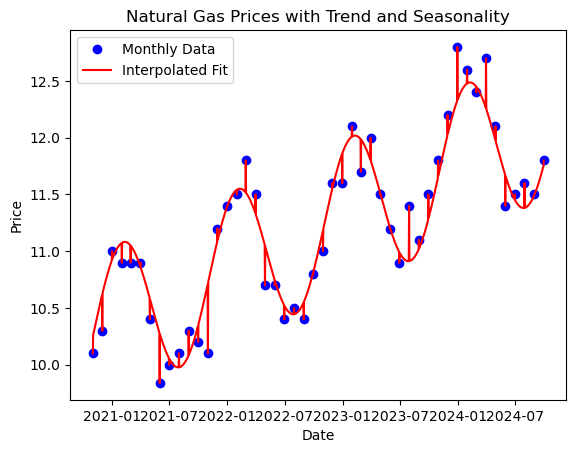

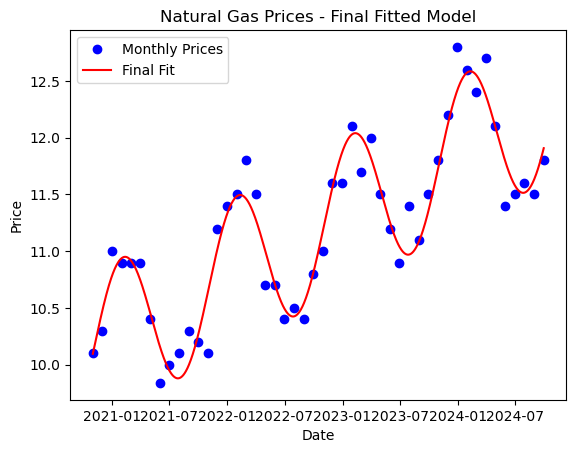

Final Fit Slope: 0.0015, Final Fit Intercept: 10.1378


In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import date, timedelta

# =========================
# 1. SETUP AND LOAD DATA
# =========================
# Get current working directory
cwd = os.getcwd()
print(f"Current working directory: {cwd}")

# Load data
file_path = 'Nat_Gas.csv'
df = pd.read_csv(file_path, parse_dates=['Dates'])
prices = df['Prices'].values
dates = df['Dates'].values

# Plot raw data
fig, ax = plt.subplots()
ax.plot(dates, prices, label='Natural Gas Prices', color='blue')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.set_title('Natural Gas Prices')
ax.tick_params(axis='x', rotation=45)
plt.legend()
plt.show()

# =========================
# 2. CREATE TIME INDEX
# =========================
# Define start and end dates for analysis
start_date = date(2020, 10, 31)
end_date = date(2024, 9, 30)

# Generate list of month-end dates
months = []
year = start_date.year
month = start_date.month + 1

while True:
    current = date(year, month, 1) + timedelta(days=-1)
    months.append(current)
    if current.month == end_date.month and current.year == end_date.year:
        break
    month = (month % 12) + 1
    if month == 1:
        year += 1

# Convert to days from start date
days_from_start = [(day - start_date).days for day in months]

# =========================
# 3. LINEAR REGRESSION (TREND)
# =========================
# Linear regression function
def simple_regression(x, y):
    xbar = np.mean(x)
    ybar = np.mean(y)
    slope = np.sum((x - xbar) * (y - ybar)) / np.sum((x - xbar) ** 2)
    intercept = ybar - slope * xbar
    return slope, intercept

# Perform regression
time = np.array(days_from_start)
slope, intercept = simple_regression(time, prices)

# Plot trend
plt.plot(time, prices, label='Actual Prices', color='blue')
plt.plot(time, time * slope + intercept, label='Trend Line', color='red')
plt.xlabel('Days from Start Date')
plt.ylabel('Price')
plt.title('Linear Trend of Natural Gas Prices')
plt.legend()
plt.show()

print(f"Slope: {slope:.4f}, Intercept: {intercept:.4f}")

# =========================
# 4. FIT SINUSOIDAL VARIATION (SEASONALITY)
# =========================
# Remove trend to isolate seasonal component
sin_prices = prices - (time * slope + intercept)

# Create sine and cosine components for seasonal cycle (~12 months)
sin_time = np.sin(time * 2 * np.pi / 365)
cos_time = np.cos(time * 2 * np.pi / 365)

# Bilinear regression to estimate seasonal components
def bilinear_regression(y, x1, x2):
    slope1 = np.sum(y * x1) / np.sum(x1 ** 2)
    slope2 = np.sum(y * x2) / np.sum(x2 ** 2)
    return slope1, slope2

slope1, slope2 = bilinear_regression(sin_prices, sin_time, cos_time)

# Recover amplitude and phase shift
amplitude = np.sqrt(slope1 ** 2 + slope2 ** 2)
shift = np.arctan2(slope2, slope1)

# Plot seasonality
plt.plot(time, sin_prices, label='Detrended Prices', color='blue')
plt.plot(time, amplitude * np.sin(time * 2 * np.pi / 365 + shift), label='Seasonality Fit', color='red')
plt.title('Seasonality Fit')
plt.xlabel('Days from Start Date')
plt.ylabel('Price')
plt.legend()
plt.show()

print(f"Amplitude: {amplitude:.4f}, Phase Shift: {shift:.4f} radians")

# =========================
# 5. INTERPOLATION / EXTRAPOLATION FUNCTION
# =========================
def interpolate(date):
    days = (date - pd.Timestamp(start_date)).days
    if days in days_from_start:
        # Exact match
        return prices[days_from_start.index(days)]
    else:
        # Predict using trend + seasonality model
        return amplitude * np.sin(days * 2 * np.pi / 365 + shift) + days * slope + intercept

# Create continuous date range for plotting
continuous_dates = pd.date_range(start=pd.Timestamp(start_date), end=pd.Timestamp(end_date), freq='D')

# Generate predicted values
smoothed_prices = [interpolate(date) for date in continuous_dates]

# Plot full dataset with interpolated values
plt.plot(dates, prices, 'o', label='Monthly Data', color='blue')
plt.plot(continuous_dates, smoothed_prices, label='Interpolated Fit', color='red')
plt.title('Natural Gas Prices with Trend and Seasonality')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# =========================
# 6. FINAL MODEL FITTING
# =========================
# Fit linear trend + sinusoidal model directly
fit_slope, fit_intercept = simple_regression(time, prices - amplitude * np.sin(time * 2 * np.pi / 365 + shift))

# Final fitted model
plt.plot(dates, prices, 'o', label='Monthly Prices', color='blue')
plt.plot(
    continuous_dates,
    amplitude * np.sin((continuous_dates - pd.Timestamp(start_date)).days * 2 * np.pi / 365 + shift) +
    (continuous_dates - pd.Timestamp(start_date)).days * fit_slope + fit_intercept,
    label='Final Fit',
    color='red'
)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Natural Gas Prices - Final Fitted Model')
plt.legend()
plt.show()

print(f"Final Fit Slope: {fit_slope:.4f}, Final Fit Intercept: {fit_intercept:.4f}")


